# Heat Equation
Consider 1D heat equation by space-time discretization with discontinuous galerkin method.

$$\left\{
\begin{aligned}
&\frac{\partial u}{\partial t}-\Delta u = f\qquad for \ Q=\Omega \times (0,T)\\
&u(x,t)=g_D\qquad for \ \Sigma_D=\Gamma_D\times(0,T)\\
&n\cdot \nabla_x u = g_N\qquad for \ \Sigma_N=\Gamma_N\times(0,T)\\
&u(x,0)=u_0\qquad for \ \Sigma_0=\Omega\times 0
\end{aligned}
\right.$$

Here we set $g_D=0, u_0 = sin(\pi x)$ and only the dirichlet condition. Also $T = 1, \Omega = [0,1]$

9 points in the whole domain
16 faces in the whole domain
8 elements in the whole domain
8 interior edges; 4 boundary edges; 2 inital t boundary; 2 final t boundary;
Mesh: [[7 2 4]
 [5 0 4]
 [4 8 3]
 [4 3 5]
 [4 0 6]
 [6 1 4]
 [4 1 7]
 [4 2 8]]
points (x, t): [[0.  0. ]
 [1.  0. ]
 [1.  1. ]
 [0.  1. ]
 [0.5 0.5]
 [0.  0.5]
 [0.5 0. ]
 [1.  0.5]
 [0.5 1. ]]
edges: [[7 2]
 [2 4]
 [4 7]
 [5 0]
 [0 4]
 [4 5]
 [4 8]
 [8 3]
 [3 4]
 [3 5]
 [0 6]
 [6 4]
 [6 1]
 [1 4]
 [1 7]
 [2 8]] 16


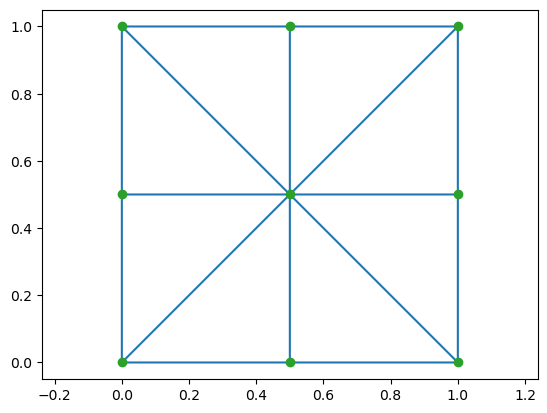

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from triangle import triangulate
from mesh import *


######################################################################################
# generate mesh with Triangle
v = [[0, 0], [1, 0], [1, 1], [0, 1]]
segments = [[0, 1], [1, 2], [2, 3], [3, 0]]
t = triangulate({"vertices": v, 'segments': segments}, "pq30a0.2e")
Mesh = t["triangles"]
points = t["vertices"]
edges = t["edges"]
Nv = points.shape[0]
Nelt = Mesh.shape[0]

######################################################################################
# create list of vertices, element and face
meshelt = []
for i in range(Nelt):
    tmpelt = element(Mesh[i])
    meshelt.append(tmpelt)

meshvertex = []
for i in range(Nv):
    meshvertex.append(points[i])

meshface = []
Nface = edges.shape[0]
Nif = 0; Nbf = 0; Nibf = 0; Nfbf = 0
for i in range(Nface):
    neighbor = [] # two cells alone the edge
    for k in range(Nelt):
        # assemble adjacency matrix and edge info
        if (edges[i][0] in Mesh[k]) and (edges[i][1] in Mesh[k]):
            neighbor.append(k)
    if len(neighbor) == 2:
        e = face(edges[i], neighbor)
        meshface.append(e)
        Nif += 1
    elif len(neighbor) == 1:
        e = face(edges[i], neighbor)
        if meshvertex[edges[i][0]][1]<1e-9 and meshvertex[edges[i][1]][1]<1e-9:
            e.bctype = -1
            Nibf += 1
        elif abs(meshvertex[edges[i][0]][1] - 1)<1e-9 and abs(1 - meshvertex[edges[i][1]][1])<1e-9:
            e.bctype = -2
            Nfbf += 1
        else:
            e.bctype = 1
            Nbf += 1
        meshface.append(e)

######################################################################################
# print information about the mesh
print(Nv, 'points in the whole domain')
print(Nface, 'faces in the whole domain')
print(Nelt, 'elements in the whole domain')
print(Nif, 'interior edges;', Nbf, 'boundary edges;', Nibf, 'inital t boundary;', Nfbf, 'final t boundary;')

print('Mesh:',Mesh)
print('points (x, t):', points)
print('edges:', edges, Nface)


######################################################################################
# plot the mesh
plt.triplot(points[:,0], points[:,1], Mesh) 
plt.plot(points[:,0], points[:,1], 'o') 
plt.axis('equal')
plt.show() 

In [38]:
######################################################################################
# define space time basis function phi(x, t) x\in [0,1] and t\in[0,1]
Nloc = 6
# 1
def phi0(p):
    return 1
# x
def phi1(p):
    return p[0]
# t
def phi2(p):
    return p[1]
# x^2
def phi3(p):
    return p[0] * p[0]
# xt
def phi4(p):
    return p[0] * p[1]
# t^2
def phi5(p):
    return p[1] * p[1]

def grad_phi0(p): 
    return np.array([0.0, 0.0])
# (1,0)
def grad_phi1(p): 
    return np.array([1.0, 0])
# (0,1)
def grad_phi2(p): 
    return np.array([0, 1.0])
# (2x,0)
def grad_phi3(p): 
    return np.array([2 * p[0], 0])
# (x,y)
def grad_phi4(p): 
    return np.array([p[1], p[0]])
# (0,2y)
def grad_phi5(p): 
    return np.array([0, 2 * p[1]])

phi = {0:phi0, 1:phi1, 2:phi2, 3:phi3, 4:phi4, 5:phi5}
grad_phi = {0:grad_phi0, 1:grad_phi1, 2:grad_phi2, 3:grad_phi3, 4:grad_phi4, 5:grad_phi5}
ji = phi.get(1)
print(ji(np.array([1,2])))

1


In [39]:
from utils import *
from condition import *
def computeAF(E: element):
    A = np.zeros((Nloc, Nloc))
    F = np.zeros(Nloc)
    w = np.array([1.0/6, 1.0/6, 1.0/6])
    points = np.array([[2.0/3, 1.0/6], [1.0/6, 1.0/6], [1.0/6, 2.0/3]])
    NG = w.shape[0]
    p1 = meshvertex[E.vertex[0]]; p2 = meshvertex[E.vertex[1]]; p3 = meshvertex[E.vertex[2]]
    BE, bE = computeBE(p1, p2, p3)
    invBE = np.linalg.inv(BE)
    detBE = np.linalg.det(BE)   
    for k in range(NG):
        realcor = hat2E(BE, bE, points[k])
        f = source(realcor)
        for i in range(Nloc):
            phii = phi.get(i)(points[k])
            phiix = np.dot(invBE[:, 0], grad_phi.get(i)(points[k]))
            for j in range(Nloc):
                phijx = np.dot(invBE[:, 0], grad_phi.get(j)(points[k]))
                phij = phi.get(j)(points[k])
                A[i][j] += detBE * w[k] * phiix * phijx
                A[i][j] -= detBE * w[k] * phij * phiix
            F[i] += w[k] * detBE * f * phii
    return A, F


# computeAF(meshelt[0])

In [40]:
def normvec(e: face):
    '''
    if e is interior edge, then norm vector point from E1 point to E2
    if e is boundary edge, then norm vector point out E1
    nx is normvec[0], nt is normvec[1]
    '''
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    v0 = p2 - p1
    if e.bctype == 0:
        E1 = meshelt[e.neighbor[0]]; E2 = meshelt[e.neighbor[1]]
        # print(e.neighbor[0], e.neighbor[1])
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        n2 = E2.vertex[~np.isin(E2.vertex, inx)][0]
        # print(n1, n2)
        v1 = meshvertex[n2] - meshvertex[n1]
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return tmpvec / np.linalg.norm(tmpvec)
        else:
            return -tmpvec / np.linalg.norm(tmpvec)
    elif e.bctype != 0:
        E1 = meshelt[e.neighbor[0]]
        inx = np.array([e.vertex[0], e.vertex[1]])
        n1 = E1.vertex[~np.isin(E1.vertex, inx)][0]
        v1 = meshvertex[n1] - p1
        tmpvec = np.array([-v0[1], v0[0]])
        t = np.dot(v1, tmpvec)
        if t > -1e-10:
            return -tmpvec / np.linalg.norm(tmpvec)
        else:
            return tmpvec / np.linalg.norm(tmpvec)


In [41]:
def computeM(e:face):
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    leng = length(p1, p2)
    nvec = normvec(e)
    s = np.array([-0.86113631, -0.33998104, 0.33998104, 0.86113631])  
    w = np.array([0.34785485, 0.65214515, 0.65214515, 0.34785485]) / 2
    NG = w.shape[0]
    if e.bctype == 0:
        # e is interior edge
        M11 = np.zeros((Nloc, Nloc))
        M22 = np.zeros((Nloc, Nloc))
        M21 = np.zeros((Nloc, Nloc))
        M12 = np.zeros((Nloc, Nloc))
        E1 = meshelt[e.neighbor[0]]; E2 = meshelt[e.neighbor[1]]
        BE1, bE1 = computeBE(meshvertex[E1.vertex[0]], meshvertex[E1.vertex[1]], meshvertex[E1.vertex[2]])
        BE2, bE2 = computeBE(meshvertex[E2.vertex[0]], meshvertex[E2.vertex[1]], meshvertex[E2.vertex[2]])
        invBE1 = np.linalg.inv(BE1)
        invBE2 = np.linalg.inv(BE2)
        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE1 = E2hat(BE1, bE1, realcor)
            refcorE2 = E2hat(BE2, bE2, realcor)
            # compute M_k^{11}
            for i in range(Nloc):
                phii1 = phi.get(i)(refcorE1)
                phii1x = np.dot(invBE1[:, 0], grad_phi.get(i)(refcorE1))
                for j in range(Nloc):
                    phij1 = phi.get(j)(refcorE1)
                    phij1x = np.dot(invBE1[:, 0], grad_phi.get(j)(refcorE1))
                    M11[i][j] += -0.5 * w[k] * leng * nvec[0] * phij1x * phii1
                    M11[i][j] += eps * 0.5 * w[k] * leng * phii1x * phij1 * nvec[0]
                    M11[i][j] += sigma * w[k] * phii1 * nvec[0] * phij1 * nvec[0]
            # compute M_k^{22}
            for i in range(Nloc):
                phii2 = phi.get(i)(refcorE2)
                phii2x = np.dot(invBE2[:, 0], grad_phi.get(i)(refcorE2))
                for j in range(Nloc):
                    phij2 = phi.get(j)(refcorE2)
                    phij2x = np.dot(invBE2[:, 0], grad_phi.get(j)(refcorE2))
                    M22[i][j] += 0.5 * w[k] * leng * nvec[0] * phij2x * phii2
                    M22[i][j] += -eps * 0.5 * w[k] * leng * phii2x * phij2 * nvec[0]
                    M22[i][j] += sigma * w[k] * phii2 * nvec[0] * phij2 * nvec[0]
            # compute M_k^{12}
            for i in range(Nloc):
                phii1 = phi.get(i)(refcorE1)
                phii1x = np.dot(invBE1[:, 0], grad_phi.get(i)(refcorE1))
                for j in range(Nloc):
                    phij2 = phi.get(j)(refcorE2)
                    phij2x = np.dot(invBE2[:, 0], grad_phi.get(j)(refcorE2))
                    M12[i][j] += -0.5 * w[k] * leng * nvec[0] * phij2x * phii1
                    M12[i][j] += -eps * 0.5 * w[k] * leng * phii1x * phij2 * nvec[0]
                    M12[i][j] += -sigma * w[k] * phii1 * nvec[0] * phij2 * nvec[0]
            # compute M_k^{21}
            for i in range(Nloc):
                phii2 = phi.get(i)(refcorE2)
                phii2x = np.dot(invBE2[:, 0], grad_phi.get(i)(refcorE2))
                for j in range(Nloc):
                    phij1 = phi.get(j)(refcorE2)
                    phij1x = np.dot(invBE2[:, 0], grad_phi.get(j)(refcorE2))
                    M21[i][j] += 0.5 * w[k] * leng * nvec[0] * phij1x * phii2
                    M21[i][j] += eps * 0.5 * w[k] * leng * phii2x * phij1 * nvec[0]
                    M21[i][j] += -sigma * w[k] * phii2 * nvec[0] * phij1 * nvec[0]
        return M11, M22, M12, M21
    elif e.bctype == 1:
        # e is dirchlet boundary edge
        M11 = np.zeros((Nloc, Nloc))
        be = np.zeros(Nloc)
        E1 = meshelt[e.neighbor[0]]
        BE1, bE1 = computeBE(meshvertex[E1.vertex[0]], meshvertex[E1.vertex[1]], meshvertex[E1.vertex[2]])
        invBE1 = np.linalg.inv(BE1)

        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE1 = E2hat(BE1, bE1, realcor)
            # compute M_k^{11}
            for i in range(Nloc):
                phii1 = phi.get(i)(refcorE1)
                phii1x = np.dot(invBE1[:, 0], grad_phi.get(i)(refcorE1))
                for j in range(Nloc):
                    phij1 = phi.get(j)(refcorE1)
                    phij1x = np.dot(invBE1[:, 0], grad_phi.get(j)(refcorE1))
                    M11[i][j] += -w[k] * leng * nvec[0] * phij1x * phii1
                    M11[i][j] += eps * w[k] * leng * phii1x * phij1 * nvec[0]
                    M11[i][j] += sigma * w[k] * phii1 * nvec[0] * phij1 * nvec[0]
                be[i] += w[k] * (eps * leng * phii1x * nvec[0] + sigma * phii1 * nvec[0] * nvec[0]) * dirichlet(refcorE1)
        # return M11, be
        return M11, be

In [42]:
def computeN(e: face):
    p1 = meshvertex[e.vertex[0]]; p2 = meshvertex[e.vertex[1]]
    leng = length(p1, p2)
    nvec = normvec(e)
    nt = nvec[1]
    s = np.array([-0.86113631, -0.33998104, 0.33998104, 0.86113631])  
    w = np.array([0.34785485, 0.65214515, 0.65214515, 0.34785485]) / 2
    NG = w.shape[0]
    if e.bctype == 0:
        E1 = meshelt[e.neighbor[0]]; E2 = meshelt[e.neighbor[1]]
        BE1, bE1 = computeBE(meshvertex[E1.vertex[0]], meshvertex[E1.vertex[1]], meshvertex[E1.vertex[2]])
        BE2, bE2 = computeBE(meshvertex[E2.vertex[0]], meshvertex[E2.vertex[1]], meshvertex[E2.vertex[2]])
        invBE1 = np.linalg.inv(BE1)
        invBE2 = np.linalg.inv(BE2)
        if nt > 0:
            N11 = np.zeros((Nloc, Nloc))
            N21 = np.zeros((Nloc, Nloc))
            for k in range(NG):
                realcor = ref2I(p1, p2, s[k])
                refcorE1 = E2hat(BE1, bE1, realcor)
                refcorE2 = E2hat(BE2, bE2, realcor)
                for j in range(Nloc):
                    phij1 = phi.get(j)(refcorE1)
                    for i in range(Nloc):
                        phii1 = phi.get(i)(refcorE1)
                        phii2 = phi.get(i)(refcorE2)
                        N11[i][j] += w[k] * leng * phii1 * phij1 * nt
                        N21[i][j] -= w[k] * leng * phii2 * phij1 * nt
            return N11, N21
        elif abs(nt) < 1e-10:
            pass
        elif nt < 0:
            N22 = np.zeros((Nloc, Nloc))
            N12 = np.zeros((Nloc, Nloc))
            for k in range(NG):
                realcor = ref2I(p1, p2, s[k])
                refcorE1 = E2hat(BE1, bE1, realcor)
                refcorE2 = E2hat(BE2, bE2, realcor)
                for j in range(Nloc):
                    phij2 = phi.get(j)(refcorE2)
                    for i in range(Nloc):
                        phii1 = phi.get(i)(refcorE1)
                        phii2 = phi.get(i)(refcorE2)
                        N12[i][j] += w[k] * leng * phii1 * phij2 * nt
                        N22[i][j] -= w[k] * leng * phii2 * phij2 * nt
            return N12, N22
    elif e.bctype == -1:
        be = np.zeros(Nloc)
        E = meshelt[e.neighbor[0]]
        BE, bE = computeBE(meshvertex[E.vertex[0]], meshvertex[E.vertex[1]], meshvertex[E.vertex[2]])
        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE = E2hat(BE, bE, realcor)
            iu = initu(refcorE)
            for i in range(Nloc):
                phii = phi.get(i)(refcorE)
                be[i] += w[k] * iu * refcorE * phii * leng
        return be

    elif e.bctype == -2:
        N11 = np.zeros((Nloc, Nloc))
        E = meshelt[e.neighbor[0]]
        BE, bE = computeBE(meshvertex[E.vertex[0]], meshvertex[E.vertex[1]], meshvertex[E.vertex[2]])
        for k in range(NG):
            realcor = ref2I(p1, p2, s[k])
            refcorE = E2hat(BE, bE, realcor)
            for i in range(Nloc):
                phii = phi.get(i)(refcorE)
                for j in range(Nloc):
                    phij = phi.get(j)(refcorE)
                    N11[i][j] += phii * phij * w[k] * leng
        return N11

In [43]:
Ntol = Nelt * Nloc
Fglobal = np.zeros(Ntol)
Aglobal = np.zeros((Ntol, Ntol))
for k in range(Nelt):
    E = meshelt[k]
    A, F = computeAF(E)
    for i in range(Nloc):
        ie = i + k * Nloc
        Fglobal[i] += F[i]
        for j in range(Nloc):
            je = j + k * Nloc
            Aglobal[ie][je] += A[i][j]

for k in range(Nface):
    e = meshface[k]
    if e.bctype == 0:
        noe1 = e.neighbor[0]
        noe2 = e.neighbor[1]
        M11, M22, M12, M21 = computeM(e)
        for i in range(Nloc):
            ie = i + noe1 * Nloc
            for j in range(Nloc):
                je = j + noe1 * Nloc
                Aglobal[ie][je] += M11[i][j]

                
        for i in range(Nloc):
            ie = i + noe2 * Nloc
            for j in range(Nloc):
                je = j + noe2 * Nloc
                Aglobal[ie][je] += M22[i][j]
                
        for i in range(Nloc):
            ie = i + noe1 * Nloc
            for j in range(Nloc):
                je = j + noe2 * Nloc
                Aglobal[ie][je] += M12[i][j]
                
        for i in range(Nloc):
            ie = i + noe2 * Nloc
            for j in range(Nloc):
                je = j + noe1 * Nloc
                Aglobal[ie][je] += M21[i][j]
                
    elif e.bctype == 1:
        noe1 = e.neighbor[0]
        M11, be = computeM(e)
        for i in range(Nloc):
            ie = i + noe1 * Nloc
            Fglobal[ie] += be[i]
            for j in  range(Nloc):
                je = j + noe1 * Nloc
                Aglobal[ie][je] += M11[i][j]

for k in range(Nface):
    e = meshface[k]
    nvec = normvec(e)
    nt = nvec[1]
    if e.bctype == 0:
        noe1 = e.neighbor[0]
        noe2 = e.neighbor[1]
        if nt > 0:
            N11, N21 = computeN(e)
            for i in range(Nloc):
                ie = i + noe1 * Nloc
                for j in range(Nloc):
                    je = j + noe1 * Nloc
                    Aglobal[ie][je] += N11[i][j]
                    
            for i in range(Nloc):
                ie = i + noe2 * Nloc
                for j in range(Nloc):
                    je = j + noe1 * Nloc
                    Aglobal[ie][je] += N21[i][j]
        elif abs(nt) < 1e-10:
            pass
        elif nt < 0:
            N12, N22 = computeN(e)
            for i in range(Nloc):
                ie = i + noe2 * Nloc
                for j in range(Nloc):
                    je = j + noe2 * Nloc
                    Aglobal[ie][je] += N22[i][j]
                    
            for i in range(Nloc):
                ie = i + noe1 * Nloc
                for j in range(Nloc):
                    je = j + noe2 * Nloc
                    Aglobal[ie][je] += N12[i][j]    
    elif e.bctype == -1:
        noe1 = e.neighbor[0]
        be = computeN(e)
        for i in range(Nloc):
            ie = i + noe1 * Nloc
            Fglobal[ie] += be[i]
    elif e.bctype == -2:
        noe1 = e.neighbor[0]
        N11 = computeN(e)
        for i in range(Nloc):
            ie = i + noe1 * Nloc
            for j in  range(Nloc):
                je = j + noe1 * Nloc
                Aglobal[ie][je] += N11[i][j]

NameError: name 'eps' is not defined